In [45]:
import numpy as np, pandas as pd
from glob import glob
from matplotlib import pyplot as plt

%matplotlib inline

Sample was generated using queries similar to the following, in slices in Galactic longitude. So assuming distances from Bailer-Jones, we can pick out lots of bright things!
```
SELECT gaia.source_id, wise_match.original_ext_source_id, wise_match.allwise_oid, wise.designation, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.a_g_val, gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, gaia_dist.r_est, gaia_dist.r_lo, gaia_dist.r_hi, gaia_dist.r_len, wise.w1mpro, wise.w1mpro_error, wise.w2mpro, wise.w2mpro_error
FROM gaiadr2.gaia_source as gaia 
INNER JOIN external.gaiadr2_geometric_distance as gaia_dist ON gaia.source_id = gaia_dist.source_id
INNER JOIN gaiadr2.allwise_best_neighbour as wise_match ON gaia.source_id = wise_match.source_id
INNER JOIN gaiadr1.allwise_original_valid as wise ON wise_match.allwise_oid=wise.allwise_oid
WHERE  gaia.phot_g_mean_mag - 5 * log10(gaia_dist.r_est) + 5 - gaia.a_g_val <= 0
AND gaia.l >= 300
AND gaia.l < 360
AND wise.w1mpro < 14
AND gaia_dist.result_flag > 0 
```

In [46]:
tables = glob('bright_*result.csv')
#check that we're only getting the files we want
tables

['bright_0-15-result.csv',
 'bright_120-180-result.csv',
 'bright_15-30-result.csv',
 'bright_180-240-result.csv',
 'bright_240-270-result.csv',
 'bright_270-285-result.csv',
 'bright_285-300-result.csv',
 'bright_30-45-result.csv',
 'bright_300-315-result.csv',
 'bright_315-330-result.csv',
 'bright_330-345-result.csv',
 'bright_345-360-result.csv',
 'bright_45-60-result.csv',
 'bright_60-75-result.csv',
 'bright_75-90-result.csv',
 'bright_90-120-result.csv']

In [47]:
#Put together the individual results
dfs = []
for t in tables:
    temp = pd.read_csv(t)
    dfs.append(temp)
    
result = pd.concat(dfs)

In [48]:
result.columns

Index(['source_id', 'original_ext_source_id', 'allwise_oid', 'designation',
       'ra', 'dec', 'parallax', 'parallax_error', 'a_g_val', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'r_est', 'r_lo', 'r_hi',
       'r_len', 'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error'],
      dtype='object')

In [50]:
#Synthesize Gaia M_G mag
M_G = result['phot_g_mean_mag'] - 5 * np.log10(result['r_est']) + 5 - result['a_g_val']
result['M_G'] = M_G

#Now synthesize unextincted colors, using coefficients from Malhan, Ibata & Martin (2018a)
ag_av = 0.85926
ab_av = 1.06794
ar_av = 0.65199

e_br = (result['a_g_val']/ag_av)*(ab_av - ar_av)
result['E(BP-RP)'] = e_br
result['(BP_RP)_0'] = result['phot_bp_mean_mag'] - result['phot_rp_mean_mag'] - result['E(BP-RP)']

len(result)

3846981

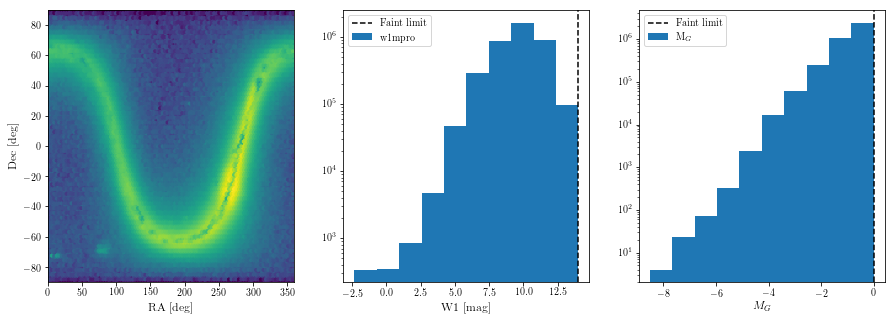

In [57]:
#Check for all the conditions we have
fig, axes = plt.subplots(1,3,figsize=(15,5))

axes[0].hexbin(result['ra'],result['dec'],bins='log')
axes[0].set(xlim=(0,360),ylim=(-90,90),xlabel='RA [deg]',ylabel='Dec [deg]')

axes[1].hist(result['w1mpro'])
axes[1].axvline(x=14,label='Faint limit',ls='--',c='k')
axes[1].set(xlabel='W1 [mag]',yscale='log')
axes[1].legend()

axes[2].hist(result['M_G'])
axes[2].axvline(x=0,label='Faint limit',ls='--',c='k')
axes[2].legend()
axes[2].set(xlabel=r'$M_G$',yscale='log');

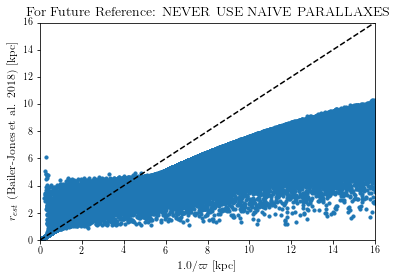

In [75]:
plt.scatter(1.0/result['parallax'],1.0e-3*result['r_est'],s=10)
plt.xlim(0,16)
plt.ylim(0,16)
plt.plot([0,16],[0,16],'--k',label='1 to 1')
plt.xlabel(r'$1.0/\varpi$ [kpc]')
plt.ylabel(r'$r_{est}$ (Bailer-Jones et al. 2018) [kpc]')
plt.title('For Future Reference: NEVER USE NAIVE PARALLAXES')
plt.savefig('NEVER_USE_PARALLAXES.png')

In [85]:
#Now let's try to isolate massive stars using MIST. Take all isochrones with initial mass > 8
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = '../MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'

mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)
mist_massive = mist[(mist['initial_mass'] >= 8)]
mist_MS = mist[(mist['EEP'] >= 202)&(mist['EEP']<=454)]

#Now, in each color bin, give me the color and magnitude of the faintest star.
col_bins = np.linspace(-0.25,3,100)
min_cols = []
min_mags = []
for i,left in enumerate(col_bins[:-1]):
    mist_subset = mist_massive[(mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']>left)&
                               (mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']<=col_bins[i+1])]
    min_point = mist_subset[mist_subset['Gaia_G_DR2Rev']==np.max(mist_subset['Gaia_G_DR2Rev'])]
    if len(min_point) != 0:
        min_cols.append((min_point['Gaia_BP_DR2Rev'].values-min_point['Gaia_RP_DR2Rev'].values)[0])
        min_mags.append((min_point['Gaia_G_DR2Rev'].values)[0])

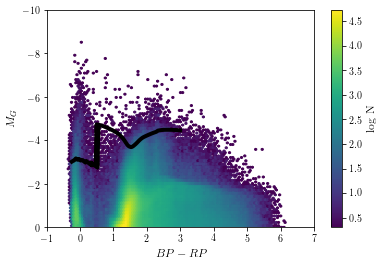

In [143]:
#So here are all of our stars, and a dividing line.
plt.hexbin(result['(BP_RP)_0'],result['M_G'],mincnt=1,bins='log')

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.colorbar(label = 'log N')

plt.plot(min_cols,min_mags,'-k',lw=4)

plt.xlabel('$BP-RP$')
plt.ylabel('$M_G$')

plt.savefig('CMD_8M_sun.png')

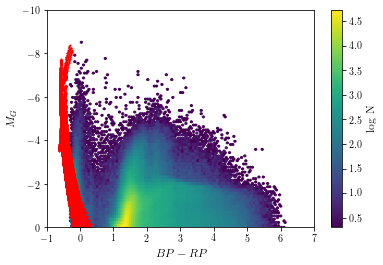

In [144]:
#So here are all of our stars, and a dividing line.
plt.hexbin(result['(BP_RP)_0'],result['M_G'],mincnt=1,bins='log')

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.colorbar(label = 'log N')

plt.scatter(mist_MS['Gaia_BP_DR2Rev']-mist_MS['Gaia_RP_DR2Rev'],mist_MS['Gaia_G_DR2Rev'],s=1,c='r')

plt.xlabel('$BP-RP$')
plt.ylabel('$M_G$')

plt.savefig('CMD_mainsequence.png')

In [60]:
#Ok, so we can run all of the colors through an interpolater
#We can then check... if M_G >= border mags, then we'll call it massive.
border_mags = np.interp(result['(BP_RP)_0'], min_cols, min_mags)

In [61]:
#We can also do some cuts using WISE data
#We'll select for SNR in flux densities instead of magnitudes...
w1_zp = 20.5
w2_zp = 19.5

w1_flux = np.power(10.0,(w1_zp - result['w1mpro'])/2.5)
w1_flux_err = w1_flux * (np.log(10.0)/2.5)*result['w1mpro_error']

w2_flux = np.power(10.0,(w2_zp - result['w2mpro'])/2.5)
w2_flux_err = w2_flux * (np.log(10.0)/2.5)*result['w2mpro_error']

w1_flux_snr = w1_flux/w1_flux_err
w2_flux_snr = w2_flux/w2_flux_err

In [62]:
#Which columns have NaNs in them?
for col,dt in zip(result.columns,result.dtypes):
    if (dt != object):
        if np.any(np.isnan(result[col])):
            print(col)

w1mpro_error
w2mpro
w2mpro_error


In [65]:
#Take only rows without NaNs, with SNR in W1 and W2 flux > 10, but fainter than the saturation limit
#From http://wise2.ipac.caltech.edu/docs/release/neowise/expsup/sec2_1c.html
good_cond = (
    (~np.isnan(result['w1mpro_error'])) & 
    (~np.isnan(result['w2mpro_error'])) & 
    (~np.isnan(result['w2mpro'])) &
    (w1_flux_snr >= 3) &
    (w2_flux_snr >= 3) &
    (result['w1mpro'] >= 8.0) &
    (result['w2mpro'] >= 7.0) &
    (result['M_G'] <= border_mags)
)
             
good = result[good_cond]
len(good)

2500

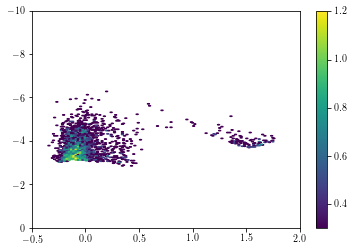

In [69]:
#The full CMD
plt.hexbin(good['(BP_RP)_0'],good['M_G'],mincnt=1,bins='log')

plt.xlim(-0.5,2)
plt.ylim(0,-10)
plt.colorbar()

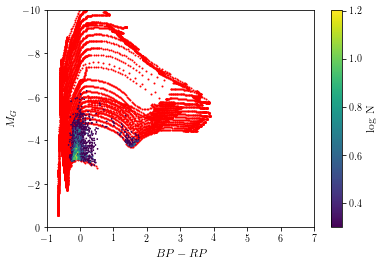

In [71]:
#So here are all of our stars, and a dividing line.

plt.scatter(mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev'],mist_massive['Gaia_G_DR2Rev'],s=1,c='r')
plt.hexbin(good['(BP_RP)_0'],good['M_G'],mincnt=1,bins='log')

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.colorbar(label = 'log N')

plt.xlabel('$BP-RP$')
plt.ylabel('$M_G$')

plt.savefig('CMD_massive_MIST.png')

Text(0,0.5,'N')

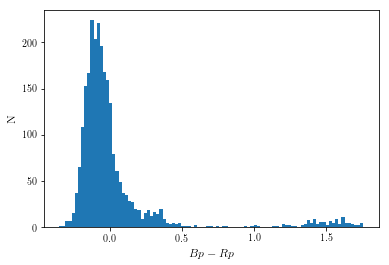

In [146]:
#Distribution of Bp - Rp
plt.hist(good['(BP_RP)_0'],bins='auto')
plt.xlabel(r'$Bp-Rp$')
plt.ylabel('N')

Text(0,0.5,'N')

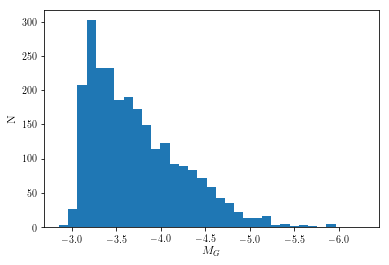

In [145]:
#Distribution of Absolute G mag
plt.hist(good['M_G'],bins='auto');
plt.gca().invert_xaxis()
plt.xlabel(r'$M_G$')
plt.ylabel('N')

# Now let's play with the sample a bit

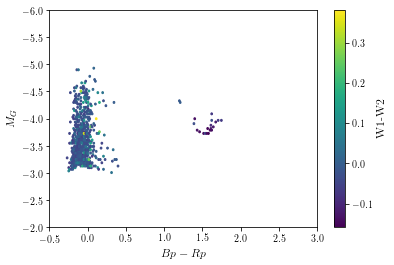

In [78]:
plt.hexbin(good['(BP_RP)_0'],good['M_G'],
           C = good['w1mpro']-good['w2mpro'],mincnt=1)

plt.xlim(-0.5,3)
plt.ylim(-2,-6)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar(label='W1-W2')
plt.savefig('massive_W1W2.png')

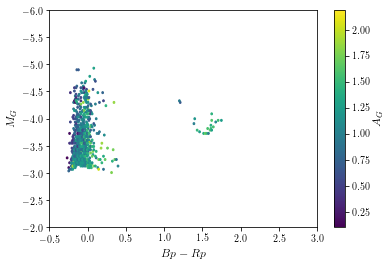

In [79]:
plt.hexbin(good['(BP_RP)_0'],good['M_G'],
           C = good['a_g_val'],mincnt=1)

plt.xlim(-0.5,3)
plt.ylim(-2,-6)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar(label='$A_G$')
plt.savefig('masive_AG.png')

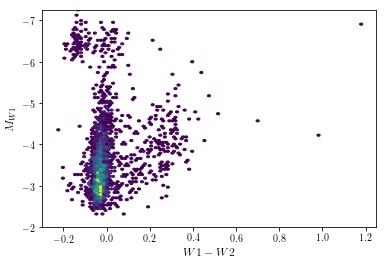

In [82]:
plt.hexbin(good['w1mpro']-good['w2mpro'],good['w1mpro'] - 5*np.log10(good['r_est']) + 5,
           mincnt=1)

#plt.xlim(-0.5,3)
plt.ylim(-2,-7.25)
plt.xlabel('$W1-W2$')
plt.ylabel('$M_{W1}$')
plt.savefig('masive_WISECMD.png')

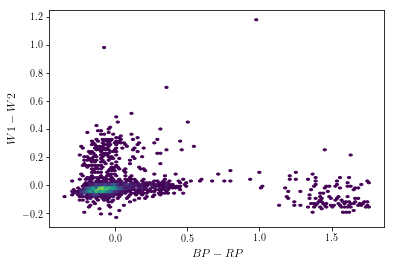

In [83]:
plt.hexbin(good['(BP_RP)_0'],good['w1mpro']-good['w2mpro'],
           mincnt=1)

#plt.xlim(-0.5,3)
#plt.ylim(-2,-7.25)
plt.ylabel('$W1-W2$')
plt.xlabel('$BP-RP$')
plt.savefig('masive_colorcolor.png')

In [84]:
#Let's write out to CSV
good.to_csv('massive.csv.gz',index=False,compression='gzip')

# Some analysis

In [124]:
MainSequence = good[good['(BP_RP)_0'] < 0.5]
PostMainSequence = good[good['(BP_RP)_0'] >= 0.5]

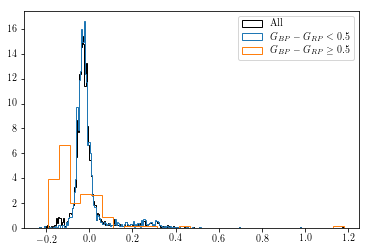

In [149]:
plt.hist(good['w1mpro']-good['w2mpro'], 
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, color='k',
         label=r'All')
plt.hist(MainSequence['w1mpro']-MainSequence['w2mpro'], 
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, 
         label=r'$G_{BP}-G_{RP} < 0.5$')
plt.hist(PostMainSequence['w1mpro']-PostMainSequence['w2mpro'],
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, 
         label=r'$G_{BP}-G_{RP} \geq 0.5$')
plt.legend()

KstestResult(statistic=0.4234794840444941, pvalue=0.0)

# Old stuff from when we didn't know how to select stars

In [25]:
def assemble_brightest_in_bins(in_df, num_per_bin=2000):
    #Let's only take the num_per_bin brightest (in W1) stars in each ~1 mag color bin. 
    #Edges should be everything bluer than 0, redder than 6, then 1 mag chunks
    dfs = []
    for i in range(8): #i is the color of the right edge of the bin, except the last which is open
        if i == 0: #everything bluer than BP-RP = 0
            subset = in_df[in_df['(BP_RP)_0'] <= 0].sort_values('w1mpro')[:num_per_bin]
        elif i == 7:
            subset = in_df[in_df['(BP_RP)_0'] > 6].sort_values('w1mpro')[:num_per_bin]
        else:
            subset = in_df[(in_df['(BP_RP)_0'] > i-1)&(in_df['(BP_RP)_0'] <= i)].sort_values('w1mpro')[:num_per_bin]
        dfs.append(subset)
    brightest_in_bins = pd.concat(dfs)
    return brightest_in_bins

In [28]:
#Let's only take the 2000 brightest (in W1) stars in each ~1 mag color bin. 
#Edges should be everything bluer than 0, redder than 6, then 1 mag chunks
brightest = assemble_brightest_in_bins(good, num_per_bin=3000)
len(brightest)

17171

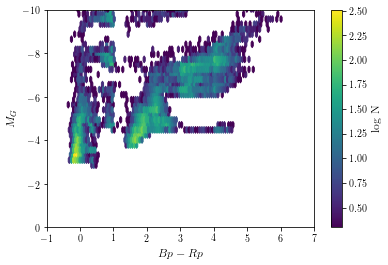

In [29]:
plt.hexbin(brightest['(BP_RP)_0'],brightest['M_G'],mincnt=1,bins='log')

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar(label='log N')
plt.savefig('brightest_in_bins.png')

In [34]:
#We wrote out the Source_ids and got back geometric distances from Bailer-Jones+ 2018

brightest_dist_df = pd.read_csv('brightest_3000_distances.csv')
res = pd.merge(brightest, brightest_dist_df, on='source_id')
res['M_G_BJ'] = res['phot_g_mean_mag'] - 5.0*np.log10(res['r_est']) + 5.0 - res['a_g_val']

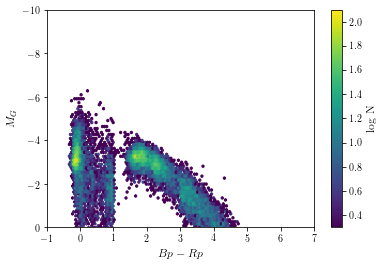

In [37]:
plt.hexbin(res['(BP_RP)_0'],res['M_G_BJ'],mincnt=1,bins='log')

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar(label='log N')
plt.savefig('brightest_in_bins_BJdist.png')

8/21/18 note: these are the ~14000 stars bluer than Bp-Rp=1 with SNR in W1-W2>=3. 
#Let's write out to CSV, and also write the source_ids so we can xmatch on ARI
good_color.to_csv('bright_clean_w1w2_gt3.csv.gz',index=False,compression='gzip')

from astropy.table import Table
good_ids = Table.from_pandas(pd.DataFrame(good['source_id']))
good_ids.write('cleaned_sourceids.csv')